In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# ja zemame prvata slika samo za prikaz
img_array = cv2.imread("Training/0/Training_3908.jpg")

In [3]:
img_array.shape # Site sliki vo databazata se so forma 48 x 48 x 3 znachi deka ima tri boi - slikata e RGB.

(48, 48, 3)

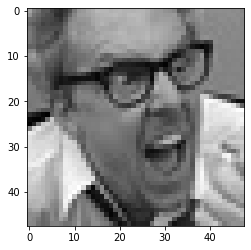

In [4]:
plt.imshow(img_array)

In [5]:
dataDirectory = "Training/" #Training Dataset

In [6]:
classes = ["0", "1", "2", "3", "4", "5", "6"]

# 0-angry
# 1-disgust
# 2-fear
# 3-happy
# 4-neutral
# 5-sad
# 6-surprise

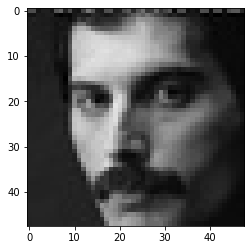

In [7]:
# jas gi imam smesteno slikite vo papka so ime Training i gi imam imenuvano kako 0, 1, 2, 3, 4, 5, 6

# 0-angry 1-disgust 2-fear 3-happy 4-neutral 5-sad 6-surprise

# sega sakam da kreiram path Training/0 pa site sliki od angry, Training/1 pa site sliki i taka natamu 
# toa go pravam so path, ama ne gi prikazhuvam site sliki bidejkji se mnogu. Samo prvata.

for category in classes:
    path = os.path.join(dataDirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

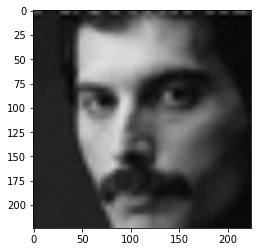

In [8]:
# 224 x 224 because we are going to use transfer learning and we need the pictures in this size
# because of the deep learning classifier. We must put our pictures into 224 x 224 size !!!

# samiot model prima input vo forma [(None, 224, 224, 3)]. Zatoa mora da ja smenime goleminata na slikite
# od 48 x 48 vo 224 x 224

img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_array.shape

(224, 224, 3)

# read all the images and convert them to array

In [10]:
# I will take all the pictures, resize them into 224 x 224 (for transfer learning purposes)
# and then i will put them into trainingData as a tupple -> (array_of_pictures, class_num). 
# class_num tell us what category is picture: angry, disqust, fear, happy, neutral, sad or suprised.

trainingData = []
def createTrainingData():
    for category in classes:
        path = os.path.join(dataDirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                trainingData.append([new_array, class_num])
            except Exception as e:
                pass

In [11]:
createTrainingData()

In [12]:
print(len(trainingData))

2800


In [13]:
# Let's shuffle the trainingData so it mixes nicely

import random
random.shuffle(trainingData)

In [14]:
# lets create X - data/features and y - labels.

X = [] 
y = []

for features,label in trainingData:
    X.append(features)
    y.append(label)
    
# and then convert the data into 4 dimensions because we are going to use CNN with depth wise NN

X = np.array(X).reshape(-1, img_size, img_size, 3) 

# Samiot vlez vo modelot e [(None, 224, 224, 3)], zatoa pravime reshape.

In [15]:
X.shape

(2800, 224, 224, 3)

In [16]:
# Now lets normalize the data:

# Samata data e prikazhana vo broevi 0-255 so koi e pretstavena nijansata na slikata. Nulata e za celosno crna boja, a
# 255 e za celosno bela boja. Site broevi izmegju se nijansi.

X = X/255.0;

In [17]:
print(len(X))

2800


In [18]:
y[0]

2

In [19]:
y[1000]

6

In [20]:
type(y) # y e lista, ama treba da bide array za da mozhe da ja iskoristime za treniranje

list

In [21]:
Y = np.array(y)

In [22]:
Y.shape

(2800,)

# Now we can define our model and start training

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
# We are going to use pretrained model.

model = tf.keras.applications.MobileNetV2()

# Ovoj model e izbran bidejkji e vekje treniran i dava dobar accuracy. Vidi trening slika. 


In [25]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [26]:
# i would like to use input_1 as my input_layer.
# that is why i resize my pictures into 224 x 224.
baseInput = model.layers[0].input

In [27]:
# Here we are going to cut off predictions Dense because we have 7 classes and we don't need 1000 classes as output. 
baseOutput = model.layers[-2].output

In [28]:
# we are going to add new layer after output of global average pooling layer
# and we are going to provide activation function
# at the end, we create dense layer with 7 outputs because we have 7 classes

finalOutput = layers.Dense(128)(baseOutput)
finalOutput = layers.Activation('relu')(finalOutput)
finalOutput = layers.Dense(64)(finalOutput)
finalOutput = layers.Activation('relu')(finalOutput)
finalOutput = layers.Dense(7, activation = 'softmax')(finalOutput) # classification layer


In [29]:
finalOutput

<tf.Tensor 'dense_2/Softmax:0' shape=(None, 7) dtype=float32>

In [30]:
newModel = keras.Model(inputs = baseInput, outputs = finalOutput)

In [31]:
newModel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [32]:
# sparse_categorical_crossentropy - bidejkji sekoja slika si ima edna kategorija. Nema kategorii pomegju.
newModel.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [33]:
# Trening na samiot model: 

# newModel.fit(X,Y, epochs = 10)

In [34]:
# Loadiranje na dobar model: 
newModel = tf.keras.models.load_model('newFiveEpoModel.h5')

In [35]:
# Zachuvuvanje na modeli:

# newModel.save('newTenEpoModel.h5')

In [36]:
newModel.evaluate

<bound method Model.evaluate of <tensorflow.python.keras.engine.functional.Functional object at 0x000001DCB5A7BC10>>

In [85]:
# Chitanje na slika shto e nadvor od bazata sliki.

frame = cv2.imread("suprisedWoman.jpg")

In [86]:
frame.shape

(280, 390, 3)

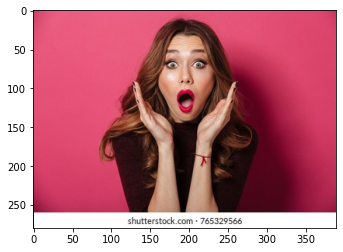

In [87]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [88]:
# Now we need face detection algorithm (gray images)

In [89]:
# iskoristen e gotov algoritam za detekcija na lica. Samiot algoritam mozhe da se najde na sledniot link:
# https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [90]:
# gray zatoa shto samiot face-detection algoritam raboti so gray images.

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [91]:
# go nema tretiot argument bidejkji sega slikata e gray
gray.shape

(280, 390)

In [99]:
# Now we need to detect the faces. 

faces = faceCascade.detectMultiScale(gray, 1.1, 4) # detektiraj go liceto i zacuvaj ja pozicijata vo faces.
# faceCascade.detectMultiScale(image, scaleFactor, minNeighbors, minSize(a,b))
for x,y,w,h in faces:
    # x, y se lokacii na slikata, w, h se sirinata i visinata.
    roi_gray = gray[y:y+h, x:x+w] # isecokot so soodvetni dimenzii na sivata slika
    roi_color = frame[y:y+h, x:x+w] # isecokot na soodvetni dimenzii na BGR slikata
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2) # BGR    (2 - ja dava debelinata na pravoagolnikot)   
    # iscrtuvame pravoagolnik za da go zememe samo liceto
    cutFaces = faceCascade.detectMultiScale(roi_gray) # gi zemame dimenziite na roi_gray slikata i gi smestuvame vo cutFaces
    if len(cutFaces) == 0:
        print("Face not detected")
    else:
        for (ex, ey, ew, eh) in cutFaces: # ex, ey se lokacijata, ew, eh se sirina i visina.
            face_roi = roi_color[ey: ey+eh, ex: ex + ew] # vo face_roi go smestuvame isecokot kako BGR slika. Samo liceto e ova

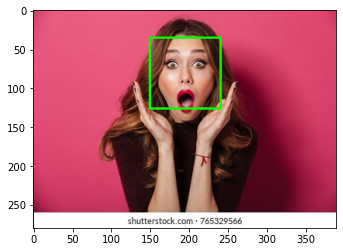

In [100]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # ova e celata slika

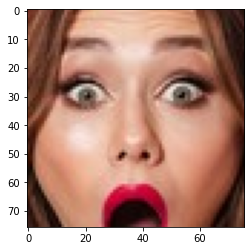

In [94]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)) # ova e face_roi - samo liceto

In [95]:
face_roi.shape # slikata e vo forma A x B x BGR, ama modelot e vo forma [(None, 224, 224, 3)], zatoa ni treba 4ta dimenzija za slikata

(76, 76, 3)

In [96]:
finalImage = cv2.resize(face_roi, (224, 224)) # pravime resize za uspesno da ja iskoristime slikata vo modelot.
finalImage = np.expand_dims(finalImage, axis = 0) # 4th dimension
finalImage = finalImage/255.0 # normalizing

In [101]:
finalImage.shape 

(1, 224, 224, 3)

In [102]:
predictions = newModel.predict(finalImage) # sega go koristime modelot za predviduvanje

In [103]:
predictions[0]

array([5.1176842e-02, 8.7805148e-03, 2.6176614e-04, 2.6761211e-06,
       2.1056019e-04, 2.6257158e-07, 9.3956739e-01], dtype=float32)

In [104]:
tmp = np.argmax(predictions)
print(tmp)

6


In [105]:
def numbers_to_expressions(argument):
    switcher = {
        0: "angry",
        1: "disgust",
        2: "fear",
        3: "happy",
        4: "neutral",
        5: "sad",
        6: "suprised",
    }
    return switcher.get(argument, "nothing")

In [106]:
print(numbers_to_expressions(tmp))

suprised


In [53]:
import cv2
import numpy as np
import tensorflow as tf

path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

# postavuvanje na pozadinata
# bela pozadina:
rectangle_bgr = (255,255,255)
# crna slika
img = np.zeros((500, 500))
# postavuvanje na random tekst. Ovoj tekst sekako podocna kje bide smenet.
text = "some text in a box"

# zemanje na koordinati na samiot textBox
(textWidth, textHeight) = cv2.getTextSize(text, font, fontScale=font_scale, thickness =1)[0]
# Ureduvanje na tekstot. Od kade da se pojavuva.
text_offset_x = 10
text_offset_y = img.shape[0] - 25

# kreiranje na padding za samata kutija.
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + textWidth + 2, text_offset_y - textHeight - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0,0,0), thickness = 1)

# cap e mojata webCam koja ja pristapuvame preku cap.read() podolu vo kodot.
cap = cv2.VideoCapture(0)

# ako kamerata ne e na kanal 0, proveri go drugiot kanal -> 1
if not cap.isOpened():
    cap = cv2.VideoCapture(1)
    # vo sprotivno, kamerata ne mozhe da se otvori.
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
    
# newModel = tf.keras.models.load_model('twentyEpoModel.h5')
    
while True:
    ret, frame = cap.read()
    # Now we need to detect the faces. 
    
    # Tuka go koristime istiot kod za detektiranje na liceto. Kodot beshe objasnet pogore.
    
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2) # BGR
        cutFaces = faceCascade.detectMultiScale(roi_gray)
        if len(cutFaces) == 0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in cutFaces:
                face_roi = roi_color[ey: ey+eh, ex: ex + ew]
                
    # ja menuvame formata na slikata, dodavame 4ta dimenzija i ja normalizirame.
                
    finalImage = cv2.resize(face_roi, (224, 224))
    finalImage = np.expand_dims(finalImage, axis = 0) # 4th dimension
    finalImage = finalImage/255.0 # normalizing
    
    
    # fontovite se proizvolno zemeni. Kako tekstot da bide ispisan.
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # pravime pretpostavki na slikata.
    predictions = newModel.predict(finalImage)
    fontScale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    # spored rezultatot od predictions(finalImage), ispisuvame na kutijata so tekst kakov e nasiot izraz na liceto.
    if(np.argmax(predictions) == 0):
        status = "Angry"
        
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(predictions) == 1):
        status = "Disgust"
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(predictions) == 2):
        status = "Fear"
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(predictions) == 3):
        status = "Happy"
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(predictions) == 4):
        status = "Sad"
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
        
    elif (np.argmax(predictions) == 5):
        status = "Suprise"
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
             
    else:
        status = "Neutral"
        x1, y1, w1, h1 = 0, 0, 175, 75 # draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
        
    cv2.imshow("Face emotion recognition - FER", frame)
    if cv2.waitKey(2) & 0xFF == ord("q"): # ako sakame da ja isklucime kamerata, na q.
        break 

cap.release()
cv2.destroyAllWindows() # bidejkji nie koristime samo eden window (za kamerata), poslednata linija kod ne e potrebna zatoa shto
# so zatvoranje na kamerata kje se izgasat site prozorci, ama ova e dobra praktika koga imame povekje prozorci.

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
